# Compulsory Assignment 1 DAT 300
Group 18? - teamme - Stian Teien

In [85]:
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

tf.random.set_seed(42)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

'''
for kaggle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

"\nfor kaggle\n\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

## Prepare data
I want the data to be scaled down and split it into three sets total.
* Train set - to train our models
* Validation set - to check for overfitting and get a good estimator for r2 score
* Test set - to test in compition

In [75]:
X_train_origin = pd.read_csv('X_train.csv')
y_train_origin = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

'''
X_train_origin = pd.read_csv('/kaggle/input/concretedata/X_train.csv')
y_train_origin = pd.read_csv('/kaggle/input/concretedata/y_train.csv')
X_test = pd.read_csv('/kaggle/input/concretedata/X_test.csv')
'''

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X_train_origin, y_train_origin, test_size=0.2, random_state=42)

In [77]:
#feature_range=(min, max)
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scale = min_max_scaler.fit_transform(X_train)
X_val_scale = min_max_scaler.fit_transform(X_val)

#sc = preprocessing.StandardScaler()
#X_train_scale = sc.fit_transform(X_train)
#X_val_scale = sc.fit_transform(X_val)

X_test_scale = min_max_scaler.fit_transform(X_test)

## Linear regression and random forest
Uses `sklearn` to make a linear regression and random forest. Compute the r2 score on validation data.

In [7]:
# Make a linear model
reg = LinearRegression().fit(X_train_scale, y_train)
reg.score(X_val_scale, y_val)

0.6122607323776583

In [22]:
# Make a random forest

regr = RandomForestRegressor(max_depth=10, random_state=42).fit(X_train_scale, y_train)
regr.score(X_val_scale, y_val)

C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.8212634897943796

## Keras model
Make a keras model. Adding callback earlystopping for finding best epoch faster.  
Technical things:  
* Optimizer &rarr; `adam`
* loss &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &rarr; `mean square error`, good for this
* metrics &nbsp;&nbsp;&nbsp; &rarr; `mean average error` (how far away from truth), `mean_absolute_percentage_error` (get % on how far from truth)

In [78]:
# Keras model

def make_model():

    model = keras.Sequential(name='concretemodel')

    model.add(keras.layers.Dense(512, activation="relu", input_shape=(8,),
                                kernel_regularizer=keras.regularizers.l2(),
                                bias_regularizer=keras.regularizers.l2()))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(512, activation="relu",
                                 kernel_regularizer=keras.regularizers.l2(),
                                 bias_regularizer=keras.regularizers.l2()))
    
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mean_absolute_percentage_error'])
    
    return model

### Cross validation
Since the data set is so small we do a cross validation to find average estimates.

In [148]:
num_epochs = 600
all_val_loss_histories = []
all_loss_histories = []
k=4
num_val_samples = len(X_train_scale) // k
patience = 50
forslag = []

for i in range(k):
    print(f'processing fold {i+1} of {k}')
    
    # Prepare the validation data: data from partition # k
    val_data = X_train_scale[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([X_train_scale[:i * num_val_samples],
                                         X_train_scale[(i + 1) * num_val_samples:]],
                                         axis=0)
    
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples],
                                            y_train[(i + 1) * num_val_samples:]],
                                            axis=0)

    # Build the Keras model (already compiled)
    model = make_model()
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=42, verbose=0,
                        callbacks= [keras.callbacks.EarlyStopping(
                                    monitor='val_loss', patience=patience, restore_best_weights=True)])

    
    forslag.append(len(history.history["val_loss"]) - 1 - patience if len(history.history["val_loss"]) < num_epochs else num_epochs)
    val_loss_history = history.history['val_loss']
    loss_history = history.history['val_loss']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    print(f'==> In fold {i} it ran {len(history.history["val_loss"])}')

processing fold 0 of 4
==> In fold 0 it ran 500
processing fold 1 of 4
==> In fold 1 it ran 500
processing fold 2 of 4
==> In fold 2 it ran 447
processing fold 3 of 4
==> In fold 3 it ran 500


In [149]:
avg_val_loss_history = []
avg_all_loss_histories = []
longest = len(max(all_val_loss_histories, key=len))
for i in range(longest):
    samlet_verdier = [all_val_loss_histories[j][i]for j in range(len(all_val_loss_histories)) if len(all_val_loss_histories[j]) > i]
    avg_val_loss_history.append(np.mean(samlet_verdier))
    
    samlet_verdier = [all_loss_histories[j][i]for j in range(len(all_loss_histories)) if len(all_loss_histories[j]) > i]
    avg_all_loss_histories.append(np.mean(samlet_verdier))


In [152]:
avg_forslag = forslag


[500, 500, 396, 500]

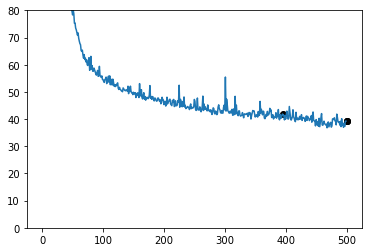

In [156]:
plt.plot(avg_val_loss_history)
for i in forslag:
    plt.scatter(i, avg_val_loss_history[i-1], c='Black')
plt.ylim([0,80])
plt.show()


In [80]:
patience = 50
history = model.fit(X_train_scale, y_train, verbose=0, 
                    batch_size=32,
                    epochs=600, validation_data=(X_val_scale, y_val),
                    callbacks= [keras.callbacks.EarlyStopping(
                        monitor='val_loss', patience=patience, restore_best_weights=True)])

lenth = len(history.history['mae'])
print(f"epochs before stop: {lenth}")

epochs before stop: 357


In [81]:
model.evaluate(X_val_scale, y_val)

124/124 [==============================] - 0s 191us/sample - loss: 39.5344 - mae: 4.3397 - mean_absolute_percentage_error: 13.2591


[39.534396756079886, 4.3396826, 13.259071]

0.8739449438101862


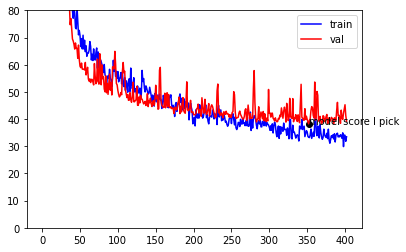

In [74]:
plt.plot(history.history['loss'], c='blue', label='train')
plt.plot(history.history['val_loss'], c='red', label='val')
plt.text(lenth-1-patience, history.history['val_loss'][lenth-1-patience],'model score I pick')
plt.scatter(lenth-1-patience, history.history['val_loss'][lenth-1-patience], c='black')
plt.legend()

plt.ylim([0,80])

print(r2_score(y_val,model.predict(X_val_scale)))

## Gridsearch to find best model
Uses sklearns gridsearch

## Save model
Save model to participate in compititon on keggle

In [602]:
pred = model.predict(X_test_scale)
df_X_test = pd.DataFrame(pred)
df_X_test = df_X_test.reset_index()
df_X_test = df_X_test.rename(columns={'index':'Id', 0:'Predicted'})

In [603]:
df_X_test.to_csv('predicted.csv', index=False)